<a href="https://colab.research.google.com/github/Jeong-jin-Han/CS454_Project/blob/main/Framework_ver2(2D).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from scipy.special import expit as sigmoid, logit
import matplotlib.pyplot as plt
import time
from typing import List, Tuple, Optional
from dataclasses import dataclass

print("✅ Imports loaded!")
print("📍 Focus: Hill climbing with adaptive compression")

# ===============================
# Warping
# ===============================
class SigmoidWarping:
    """Compress integer region to length-1 interval."""
    def __init__(self, node_index, length, steepness=5.0):
        self.node_start = int(node_index)
        self.length = int(length)
        assert self.length >= 2, "Compression length must be >= 2."
        self.node_end = self.node_start + self.length
        self.steepness = float(steepness)
        self.shift = self.length - 1  # how much right side is pulled left

    def forward(self, node):
        """X → Z"""
        node = np.atleast_1d(node).astype(float)
        position = np.zeros(len(node), dtype=float)
        for i, n in enumerate(node):
            if n < self.node_start:
                position[i] = float(n)
            elif n > self.node_end:
                position[i] = float(n) - self.shift
            else:
                if n == self.node_start:
                    position[i] = float(self.node_start)
                elif n == self.node_end:
                    position[i] = float(self.node_start + 1)
                else:
                    t = (n - self.node_start) / self.length
                    x = self.steepness * (t - 0.5)
                    s = sigmoid(x)
                    position[i] = self.node_start + s
        return position[0] if len(node) == 1 else position

    def inverse(self, position):
        """Z → X"""
        position = np.atleast_1d(position).astype(float)
        node = np.zeros(len(position), dtype=int)
        for i, pos in enumerate(position):
            if pos < self.node_start:
                node[i] = int(np.floor(pos))
            elif pos >= self.node_start + 1.0:
                node[i] = int(np.ceil(pos + self.shift))
            else:
                s = np.clip(pos - self.node_start, 0.0, 1.0)
                if s <= 0.01:
                    node[i] = self.node_start
                elif s >= 0.99:
                    node[i] = self.node_end
                else:
                    x = logit(s)
                    t = x / self.steepness + 0.5
                    node_f = self.node_start + t * self.length
                    node[i] = int(round(node_f))
        return node[0] if len(position) == 1 else node

class MetadataCompressionOriginalSpace:
    """Metadata ALWAYS in ORIGINAL X-space."""
    def __init__(self, compressions_x_space=None, steepness=5.0):
        self.metadata_x = sorted(compressions_x_space or [], key=lambda x: x[0])
        self.steepness = float(steepness)
        self.warpings = []
        self.z_positions = []
        if self.metadata_x:
            print(f"\n{'='*80}")
            print(f"📦 METADATA (Original X-space): {self.metadata_x}")
            print(f"{'='*80}")
            self._build_warpings()
            print(f"✅ Built {len(self.warpings)} compressions")
            print(f"{'='*80}\n")

    def _build_warpings(self):
        self.warpings = []
        self.z_positions = []
        cumulative_shift = 0
        for i, (x_start, x_length) in enumerate(self.metadata_x):
            assert x_length >= 2, "Each compression length must be >= 2."
            x_end = x_start + x_length
            z_start = x_start - cumulative_shift
            z_length = x_length
            print(f"  Compression #{i+1}:")
            print(f"    Original X[{x_start}, {x_end}] → Z[{z_start}, {z_start + z_length}]")
            print(f"    Saves {z_length - 1} nodes")
            warping = SigmoidWarping(z_start, z_length, self.steepness)
            self.warpings.append(warping)
            self.z_positions.append((z_start, z_length))
            cumulative_shift += (z_length - 1)

    def forward(self, node):
        """X → Z"""
        position = node
        for warping in self.warpings:
            position = warping.forward(position)
        return position

    def inverse(self, position):
        """Z → X"""
        node = position
        for warping in reversed(self.warpings):
            node = warping.inverse(node)
        return node


# ===============================
# Bidirectional Basin Detector (FIXED)
# ===============================
def detect_compression_basin(fitness_func, local_min_x, max_search=100):
    """
    Bidirectional basin detection with CORRECT priority logic:

    Rule 1: if current_fit == local_fit, continue to search (record farthest point)
    Rule 2: if current_fit > local_fit, keep searching within limited length
    Rule 3: if current_fit < local_fit, STOP (exited basin) - USE THIS EXIT POINT

    PRIORITY: Use Rule 3 exit point if found, otherwise use farthest equal-fitness point from Rule 1.

    Search both LEFT and RIGHT from local_min_x.

    Returns:
    --------
    (start_x, length) or None if no compression needed
    """
    local_min_fitness = fitness_func(local_min_x)

    print(f"  🔍 Detecting basin from local min: x={local_min_x}, fitness={local_min_fitness:.2f}")

    # LEFT search
    left_boundary = local_min_x
    farthest_left_equal = local_min_x
    found_left_equal = False
    found_left_exit = False

    for i in range(1, max_search + 1):
        current_x = local_min_x - i
        current_fitness = fitness_func(current_x)

        if abs(current_fitness - local_min_fitness) < 1e-9:  # Rule 1
            farthest_left_equal = current_x
            found_left_equal = True
            print(f"    LEFT: x={current_x}, fitness={current_fitness:.2f} == {local_min_fitness:.2f} (continue)")
        elif current_fitness > local_min_fitness:  # Rule 2
            print(f"    LEFT: x={current_x}, fitness={current_fitness:.2f} > {local_min_fitness:.2f} (plateau/hill)")
        else:  # Rule 3
            print(f"    LEFT: x={current_x}, fitness={current_fitness:.2f} < {local_min_fitness:.2f} (EXIT!)")
            left_boundary = current_x + 1
            found_left_exit = True
            break
    else:
        left_boundary = local_min_x - max_search

    # Priority: Use Rule 3 exit point if found, otherwise farthest equal-fitness
    if found_left_exit:
        print(f"    ✅ LEFT: Using Rule 3 exit boundary: x={left_boundary}")
    elif found_left_equal:
        left_boundary = farthest_left_equal
        print(f"    ✅ LEFT: Using farthest equal-fitness point (no exit found): x={left_boundary}")

    # RIGHT search
    right_boundary = local_min_x
    farthest_right_equal = local_min_x
    found_right_equal = False
    found_right_exit = False

    for i in range(1, max_search + 1):
        current_x = local_min_x + i
        current_fitness = fitness_func(current_x)

        if abs(current_fitness - local_min_fitness) < 1e-9:  # Rule 1
            farthest_right_equal = current_x
            found_right_equal = True
            print(f"    RIGHT: x={current_x}, fitness={current_fitness:.2f} == {local_min_fitness:.2f} (continue)")
        elif current_fitness > local_min_fitness:  # Rule 2
            print(f"    RIGHT: x={current_x}, fitness={current_fitness:.2f} > {local_min_fitness:.2f} (plateau/hill)")
        else:  # Rule 3
            print(f"    RIGHT: x={current_x}, fitness={current_fitness:.2f} < {local_min_fitness:.2f} (EXIT!)")
            right_boundary = current_x - 1
            found_right_exit = True
            break
    else:
        right_boundary = local_min_x + max_search

    # Priority: Use Rule 3 exit point if found, otherwise farthest equal-fitness
    if found_right_exit:
        print(f"    ✅ RIGHT: Using Rule 3 exit boundary: x={right_boundary}")
    elif found_right_equal:
        right_boundary = farthest_right_equal
        print(f"    ✅ RIGHT: Using farthest equal-fitness point (no exit found): x={right_boundary}")

    basin_length = right_boundary - left_boundary + 1

    if basin_length < 2:
        print(f"  ⚠️ No compression: basin too small (length={basin_length})")
        return None

    if not (found_left_equal or found_right_equal or found_left_exit or found_right_exit):
        print(f"  ⚠️ No compression: only Rule 2 exists")
        return None

    print(f"  ✅ Basin detected: X[{left_boundary}, {right_boundary}], length={basin_length}")
    return (left_boundary, basin_length)

print("✅ Bidirectional basin detection defined (WITH PRIORITY FIX!)")

# ===============================
# Metadata Overlap Handler
# ===============================
def merge_overlapping_compressions(compressions):
    """
    Handle overlapping compressions in ORIGINAL X-space.
    """
    if not compressions:
        return []

    sorted_comps = sorted(compressions, key=lambda x: x[0])
    merged = []

    for start, length in sorted_comps:
        end = start + length - 1

        if not merged:
            merged.append((start, length))
            continue

        last_start, last_length = merged[-1]
        last_end = last_start + last_length - 1

        if start <= last_end + 1:
            new_start = min(start, last_start)
            new_end = max(end, last_end)
            new_length = new_end - new_start + 1
            merged[-1] = (new_start, new_length)
            print(f"  🔄 Merged: ({start},{length}) + ({last_start},{last_length}) → ({new_start},{new_length})")
        else:
            merged.append((start, length))

    return merged

✅ Imports loaded!
📍 Focus: Hill climbing with adaptive compression
✅ Bidirectional basin detection defined (WITH PRIORITY FIX!)


In [3]:
# ===============================
# 2D Compression Manager
# ===============================
class CompressionManager2D:
    """Manage 1D compressions along rows (x-axis) and cols (y-axis) in 2D."""
    def __init__(self, steepness=5.0):
        self.steepness = float(steepness)
        # row-wise: y → list of (x_start, length_x)
        self.row_meta = {}
        self.row_systems = {}
        # col-wise: x → list of (y_start, length_y)
        self.col_meta = {}
        self.col_systems = {}

    # ---------- Row (x-axis) ----------
    def update_row(self, y, basin_x):
        """Update x-axis compression metadata for a fixed row y."""
        if basin_x is None:
            return
        comps = self.row_meta.get(y, [])
        comps.append(basin_x)
        comps = merge_overlapping_compressions(comps)
        self.row_meta[y] = comps
        self.row_systems[y] = MetadataCompressionOriginalSpace(
            compressions_x_space=comps,
            steepness=self.steepness
        )

    def get_row_system(self, y) -> Optional[MetadataCompressionOriginalSpace]:
        return self.row_systems.get(y, None)

    # ---------- Column (y-axis) ----------
    def update_col(self, x, basin_y):
        """Update y-axis compression metadata for a fixed column x."""
        if basin_y is None:
            return
        comps = self.col_meta.get(x, [])
        comps.append(basin_y)
        comps = merge_overlapping_compressions(comps)
        self.col_meta[x] = comps
        self.col_systems[x] = MetadataCompressionOriginalSpace(
            compressions_x_space=comps,
            steepness=self.steepness
        )

    def get_col_system(self, x) -> Optional[MetadataCompressionOriginalSpace]:
        return self.col_systems.get(x, None)


def detect_basin_along_x(fitness_func_2d, x0, y0, max_search=100):
    """Fix y = y0, detect basin along x-axis around x0."""
    def f1d(x):
        return fitness_func_2d(int(x), int(y0))
    return detect_compression_basin(f1d, local_min_x=int(x0), max_search=max_search)


def detect_basin_along_y(fitness_func_2d, x0, y0, max_search=100):
    """Fix x = x0, detect basin along y-axis around y0."""
    def f1d(y):
        return fitness_func_2d(int(x0), int(y))
    return detect_compression_basin(f1d, local_min_x=int(y0), max_search=max_search)


# ===============================
# 2D Hill-climb with Compression
# ===============================
def hill_climb_with_basin_compression_2d(
    fitness_func_2d,
    start_xy: Tuple[int, int],
    max_iterations=10,
    basin_max_search=100,
    global_min_threshold=1e-6
):
    """
    2D hill climbing with axis-aligned 1D compressions.
    - Uses separate metadata for each row (x-axis) and column (y-axis).
    """
    traj = []  # list of (x, y, f, used_compression)
    cm = CompressionManager2D(steepness=5.0)

    x, y = map(int, start_xy)
    f = fitness_func_2d(x, y)
    traj.append((x, y, f, False))

    print(f"\n🚀 2D hill climbing start at (x={x}, y={y}), f={f:.4f}\n")

    for it in range(max_iterations):
        print("="*80)
        print(f"🔄 Iteration {it+1}/{max_iterations}")
        print("="*80)

        step_count = 0
        while True:
            # ----- propose neighbors in 4 directions -----
            # horizontal neighbors (x-axis) at fixed y
            row_sys = cm.get_row_system(y)
            if row_sys is not None:
                zx = row_sys.forward(x)
                x_left  = row_sys.inverse(zx - 1)
                x_right = row_sys.inverse(zx + 1)
            else:
                x_left, x_right = x - 1, x + 1

            # vertical neighbors (y-axis) at fixed x
            col_sys = cm.get_col_system(x)
            if col_sys is not None:
                zy = col_sys.forward(y)
                y_down = col_sys.inverse(zy - 1)
                y_up   = col_sys.inverse(zy + 1)
            else:
                y_down, y_up = y - 1, y + 1

            # Evaluate 4 neighbors
            candidates = []
            candidates.append((x_left,  y,      fitness_func_2d(x_left,  y)))
            candidates.append((x_right, y,      fitness_func_2d(x_right, y)))
            candidates.append((x,       y_down, fitness_func_2d(x,       y_down)))
            candidates.append((x,       y_up,   fitness_func_2d(x,       y_up)))

            # pick best neighbor (steepest descent)
            best_x, best_y, best_f = x, y, f
            for nx, ny, nf in candidates:
                if nf < best_f:
                    best_x, best_y, best_f = nx, ny, nf

            if best_f < f:
                x, y, f = best_x, best_y, best_f
                traj.append((x, y, f, (row_sys is not None) or (col_sys is not None)))
                step_count += 1
            else:
                print(f"  📍 Climbed {step_count} steps, now at (x={x}, y={y}), f={f:.6g}")
                break

        # check convergence / global min
        if abs(f) < global_min_threshold:
            print("\n🎉 SUCCESS: reached near-global minimum")
            break

        print(f"\n⚠️ STUCK at local minimum (x={x}, y={y}), f={f:.6g}")
        print("  🔍 Detecting basins along x and y axes...")

        # ----- detect basin along x-axis (row y) -----
        basin_x = detect_basin_along_x(fitness_func_2d, x, y, max_search=basin_max_search)
        if basin_x:
            print(f"  ✅ X-axis basin at y={y}: {basin_x}")
            cm.update_row(y, basin_x)

        # ----- detect basin along y-axis (column x) -----
        basin_y = detect_basin_along_y(fitness_func_2d, x, y, max_search=basin_max_search)
        if basin_y:
            print(f"  ✅ Y-axis basin at x={x}: {basin_y}")
            cm.update_col(x, basin_y)

        if (basin_x is None) and (basin_y is None):
            print("\n  ⚠️ No compressible basin found in either axis. Stopping.")
            break

        # ----- choose restart point after compression -----
        # Simple strategy: jump past the end of each basin (if it exists)
        restart_candidates = []

        if basin_x is not None:
            bx_start, bx_len = basin_x
            bx_end = bx_start + bx_len - 1
            rx = bx_end + 1
            rf = fitness_func_2d(rx, y)
            restart_candidates.append((rx, y, rf))

        if basin_y is not None:
            by_start, by_len = basin_y
            by_end = by_start + by_len - 1
            ry = by_end + 1
            rf = fitness_func_2d(x, ry)
            restart_candidates.append((x, ry, rf))

        # pick best restart candidate
        if restart_candidates:
            restart_x, restart_y, restart_f = min(restart_candidates, key=lambda t: t[2])
            print(f"\n  ➡️ Restarting from (x={restart_x}, y={restart_y}), f={restart_f:.4f}")
            x, y, f = restart_x, restart_y, restart_f
            traj.append((x, y, f, True))
        else:
            print("\n  ⚠️ No valid restart candidate. Stopping.")
            break

    print("\n" + "="*80)
    print("🏁 FINAL 2D RESULTS")
    print("="*80)
    print(f"  Final position: (x={x}, y={y})")
    print(f"  Final fitness: {f:.6g}")
    print(f"  Total steps:   {len(traj)}")
    print(f"  Row compressions: {len(cm.row_meta)} rows")
    print(f"  Col compressions: {len(cm.col_meta)} cols")
    print("="*80 + "\n")

    return traj, cm


🎨 2D SIN × PARABOLA TEST FITNESS
  Domain: x ∈ [-15, 15], y ∈ [-15, 15] (integers)
  Global min value: 0.000000
  Global min points (should be only (x_center, 0)): [(np.int64(0), np.int64(0))]
--------------------------------------------------------------------------------
  f(0, 0)   = 0.000000
  f(0, 1)   = 0.050000
  f(1, 0) = 0.000030


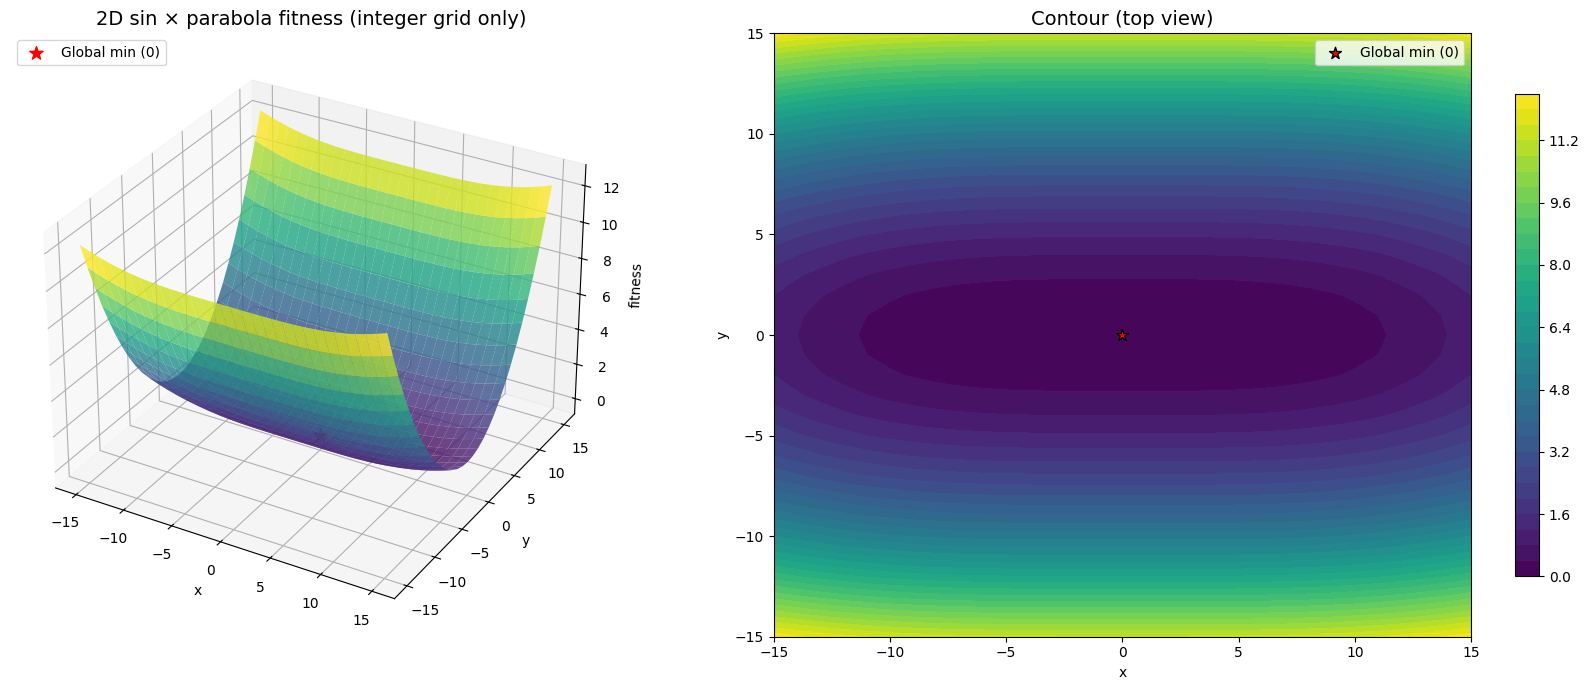


🚀 2D hill climbing start at (x=-10, y=8), f=3.4500

🔄 Iteration 1/10
  📍 Climbed 18 steps, now at (x=0, y=0), f=0

🎉 SUCCESS: reached near-global minimum

🏁 FINAL 2D RESULTS
  Final position: (x=0, y=0)
  Final fitness: 0
  Total steps:   19
  Row compressions: 0 rows
  Col compressions: 0 cols



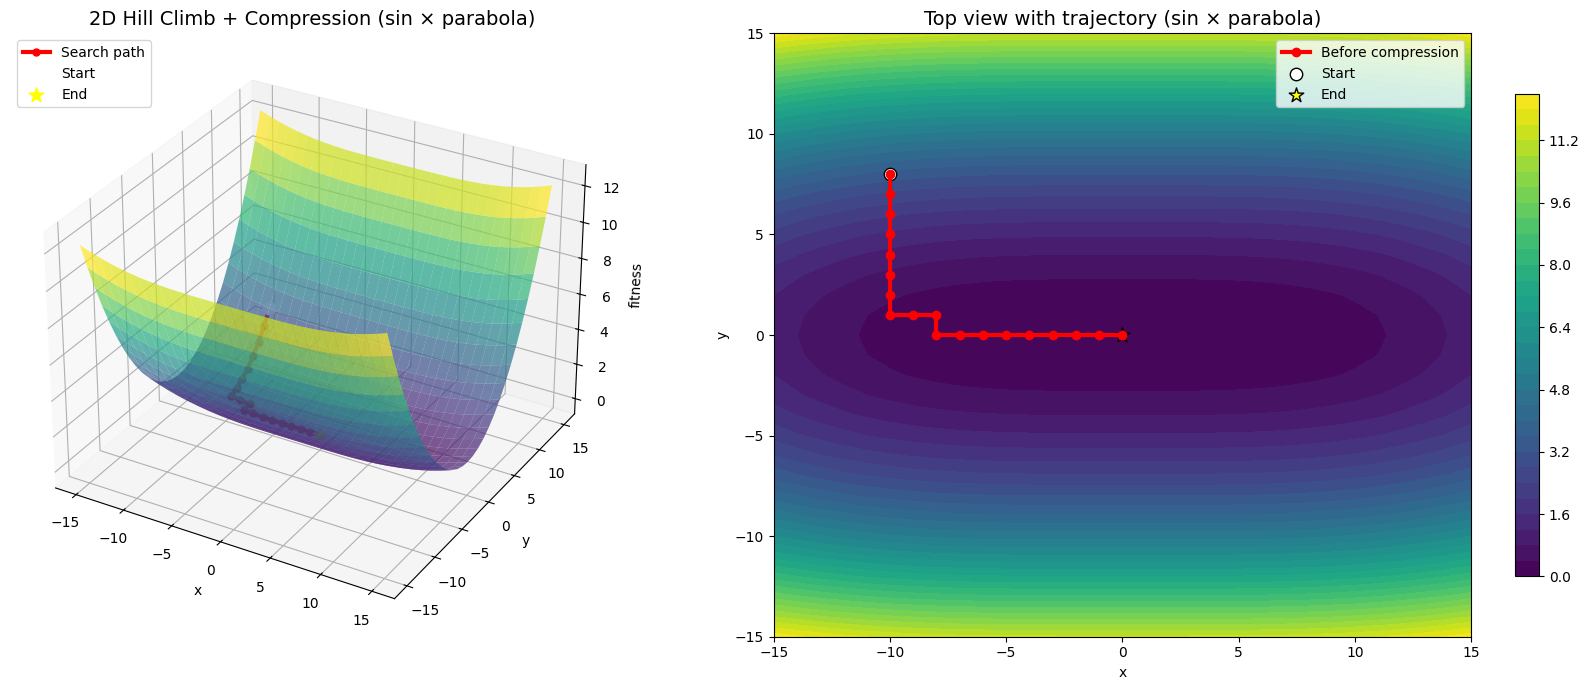

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# =========================================
# Integer-only 2D "sin × parabola" saddle-like fitness
# =========================================
def fitness_sin_parabola_2d(
    x,
    y,
    x_center=0,     # sin ridge가 오는 x 위치
    M=10,           # x 방향으로 보고 싶은 "반폭" (도메인 크기)
    alpha=0.05      # y 방향 포물선 강도
):
    """
    f(x, y) = (1 - sin(theta(x) + pi/2))^2 + alpha * y^2
            = (1 - cos(theta(x)))^2 + alpha * y^2

    - x, y: 정수 좌표 (실제로는 int로 캐스팅)
    - x 축 단면: sin에서 phase shift된 cos 모양 (ridge 형태)
    - y 축 단면: x = x_center일 때 완전한 bowl (alpha * y^2)
    - 전체 값은 항상 ≥ 0
    - (x_center, 0) 에서만 f=0 이 되는 유일한 global minimum
    """
    x = int(x)
    y = int(y)

    # x 쪽 sin (phase shift로 cos 형태)
    theta = (x - x_center) * np.pi / (2.0 * M)
    s = np.sin(theta + np.pi / 2.0)   # = cos(theta)

    term_x = (1.0 - s) ** 2          # [0, 4] 범위
    term_y = alpha * (y ** 2)        # bowl

    return float(term_x + term_y)

# 별칭
f2d = fitness_sin_parabola_2d
X_CENTER = 0
M_RANGE = 15
ALPHA = 0.05

# ===========================
# 시각화: surface + contour
# ===========================
X_MIN, X_MAX = -M_RANGE, M_RANGE
Y_MIN, Y_MAX = -M_RANGE, M_RANGE

x_grid = np.arange(X_MIN, X_MAX + 1, 1)
y_grid = np.arange(Y_MIN, Y_MAX + 1, 1)
X, Y = np.meshgrid(x_grid, y_grid)
Z = np.zeros_like(X, dtype=float)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = f2d(X[i, j], Y[i, j], x_center=X_CENTER, M=M_RANGE, alpha=ALPHA)

# global min 체크
min_val = Z.min()
min_idx = np.where(np.isclose(Z, min_val))
min_points = list(zip(X[min_idx], Y[min_idx]))

print("=" * 80)
print("🎨 2D SIN × PARABOLA TEST FITNESS")
print("=" * 80)
print(f"  Domain: x ∈ [{X_MIN}, {X_MAX}], y ∈ [{Y_MIN}, {Y_MAX}] (integers)")
print(f"  Global min value: {min_val:.6f}")
print(f"  Global min points (should be only (x_center, 0)): {min_points}")
print("-" * 80)
print(f"  f({X_CENTER}, 0)   = {f2d(X_CENTER, 0,   X_CENTER, M_RANGE, ALPHA):.6f}")
print(f"  f({X_CENTER}, 1)   = {f2d(X_CENTER, 1,   X_CENTER, M_RANGE, ALPHA):.6f}")
print(f"  f({X_CENTER+1}, 0) = {f2d(X_CENTER+1, 0, X_CENTER, M_RANGE, ALPHA):.6f}")
print("=" * 80)

fig = plt.figure(figsize=(18, 7))

# --- 3D surface ---
ax3d = fig.add_subplot(1, 2, 1, projection='3d')
ax3d.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)

ax3d.scatter(
    X_CENTER, 0,
    f2d(X_CENTER, 0, X_CENTER, M_RANGE, ALPHA),
    c='red', s=100, marker='*', label='Global min (0)'
)

ax3d.set_title("2D sin × parabola fitness (integer grid only)", fontsize=14)
ax3d.set_xlabel("x")
ax3d.set_ylabel("y")
ax3d.set_zlabel("fitness")
ax3d.legend(loc='upper left')

# --- Contour (top view) ---
ax2 = fig.add_subplot(1, 2, 2)
cs = ax2.contourf(X, Y, Z, levels=30, cmap='viridis')
fig.colorbar(cs, ax=ax2, shrink=0.8)

ax2.scatter(X_CENTER, 0, c='red', edgecolors='k', s=80, marker='*', label='Global min (0)')

ax2.set_title("Contour (top view)", fontsize=14)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

START_2D = (-10, 8)  # 예: sin ridge 옆에서 시작

try:
    traj2d, cm2d = hill_climb_with_basin_compression_2d(
        lambda xx, yy: f2d(xx, yy, x_center=X_CENTER, M=M_RANGE, alpha=ALPHA),
        start_xy=START_2D,
        max_iterations=10,
        basin_max_search=50,
        global_min_threshold=1e-6,
    )

    tx = np.array([p[0] for p in traj2d])
    ty = np.array([p[1] for p in traj2d])
    tf = np.array([p[2] for p in traj2d])
    tcomp = np.array([p[3] for p in traj2d])

    fig = plt.figure(figsize=(18, 7))

    # --- 3D surface + path ---
    ax3d = fig.add_subplot(1, 2, 1, projection='3d')
    ax3d.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7, linewidth=0, antialiased=True)
    ax3d.plot(tx, ty, tf, 'r-o', linewidth=3, markersize=5, label='Search path')
    ax3d.scatter(tx[0], ty[0], tf[0], c='white', s=80, marker='o', label='Start')
    ax3d.scatter(tx[-1], ty[-1], tf[-1], c='yellow', s=120, marker='*', label='End')

    ax3d.set_title("2D Hill Climb + Compression (sin × parabola)", fontsize=14)
    ax3d.set_xlabel("x")
    ax3d.set_ylabel("y")
    ax3d.set_zlabel("fitness")
    ax3d.legend(loc='upper left')

    # --- Contour + path ---
    ax2 = fig.add_subplot(1, 2, 2)
    cs = ax2.contourf(X, Y, Z, levels=30, cmap='viridis')
    fig.colorbar(cs, ax=ax2, shrink=0.8)

    idx_before = np.where(~tcomp)[0]
    idx_after  = np.where(tcomp)[0]

    if len(idx_before) > 0:
        ax2.plot(tx[idx_before], ty[idx_before], 'r-o',
                 label='Before compression', linewidth=3)
    if len(idx_after) > 0:
        ax2.plot(tx[idx_after], ty[idx_after], 'g-s',
                 label='After compression', linewidth=3)

    ax2.scatter(tx[0], ty[0], c='white', edgecolors='k', s=80, marker='o', label='Start')
    ax2.scatter(tx[-1], ty[-1], c='yellow', edgecolors='k', s=120, marker='*', label='End')

    ax2.set_title("Top view with trajectory (sin × parabola)", fontsize=14)
    ax2.set_xlabel("x")
    ax2.set_ylabel("y")
    ax2.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

except NameError:
    print("\n⚠️  hill_climb_with_basin_compression_2d 함수가 아직 없습니다.")
    print("    2D hill-climber를 정의한 뒤, 동일 코드로 경로를 바로 볼 수 있습니다.")


🎨 2D SIN × PARABOLA (WITH MANY LOCAL MINIMA IN X)
  Domain: x ∈ [-30, 30], y ∈ [-30, 30] (integers)
  Global min value: 0.000000
  Global min points (should be only (X_STAR, 0)): [(np.int64(0), np.int64(0))]
--------------------------------------------------------------------------------
  Example values along y=0:
    f(0, 0)       = 0.000000   (GLOBAL MIN)
    f(1, 0)     = 0.066475
    f(10, 0) = 2.010000
--------------------------------------------------------------------------------
  1D local minima along x (y=0 slice, 정수 이웃 기준):
    count = 7, positions = [np.int64(-28), np.int64(-18), np.int64(-9), np.int64(0), np.int64(9), np.int64(18), np.int64(28)] ...


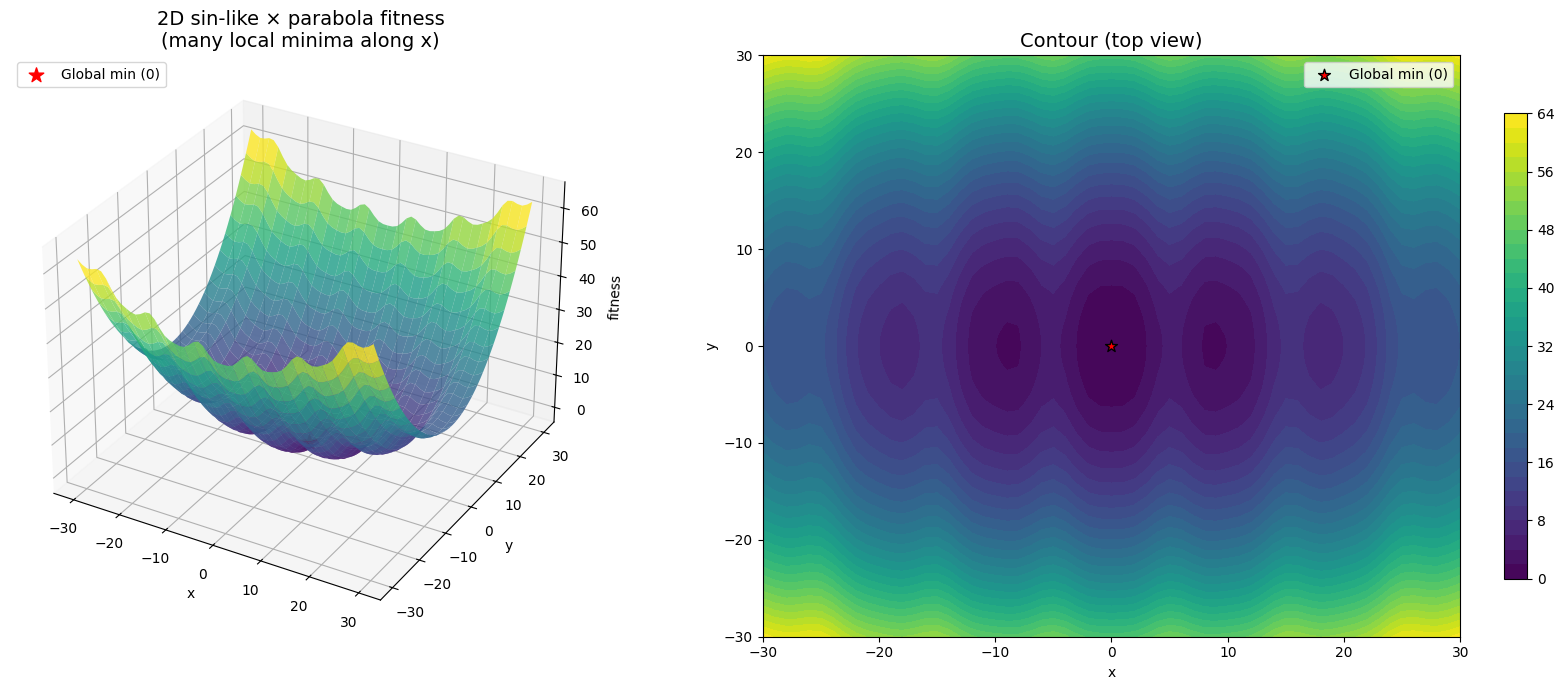

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# ===============================
# 1) Settings for the grid
# ===============================
X_MIN, X_MAX = -30, 30
Y_MIN, Y_MAX = -30, 30

X_STAR = 0         # global minimum이 놓일 x 위치 (sin local max 축)
T_PERIOD = 10      # x 방향 sin/cos 주기
EPS_X = 0.02       # x 방향에서 x* 쪽으로 살짝 기울게 하는 패널티
ALPHA_Y = 0.05     # y 방향 포물선 강도
DELTA_TIE = 0.01   # x != X_STAR 에 작은 상수 더해서 global min을 딱 하나로

# ===============================
# 2) 1D x-direction raw term
# ===============================
def base_x_raw(x: int) -> float:
    """
    x 방향 물결 + 약한 패널티.
    cos는 sin에 위상 π/2를 더한 형태라,
    'sin local max 축'과 같은 위치에서 cos=1이 되어 가장 낮게 내려감.
    """
    # sin( · + π/2 ) = cos( · ) 이므로, 여기서는 cos로 씀
    theta = 2.0 * np.pi * (x - X_STAR) / T_PERIOD
    wave = (1.0 - np.cos(theta))**2      # [0, 4] 범위의 물결
    bias = EPS_X * (x - X_STAR)**2       # x* 쪽으로 유일한 global min을 만드는 패널티
    return float(wave + bias)

# 전역에서 base_x_raw(X_STAR)를 미리 계산해서 shift로 사용
BASE_X_STAR = base_x_raw(X_STAR)

# ===============================
# 3) 최종 2D fitness 함수
# ===============================
def fitness_sin_parabola_localmin_2d(x, y):
    """
    2D 정수 격자용 테스트 함수.

    f(x, y) = [base_x_raw(x) - base_x_raw(X_STAR) + DELTA_TIE*(x != X_STAR)] + ALPHA_Y * y^2

    - 항상 f >= 0
    - 유일한 global min: (X_STAR, 0) 에서 f = 0
    - x 방향: 여러 개의 로컬 최소 존재 (cos 물결 + 패널티)
    - y 방향: bowl (y=0에서 최소)
    """
    x = int(x)
    y = int(y)

    # (원하면 여기서 domain 가드해서 밖으로 나가면 큰 페널티 줘도 됨)
    # if x < X_MIN or x > X_MAX or y < Y_MIN or y > Y_MAX:
    #     return 1e9

    term_x = base_x_raw(x) - BASE_X_STAR
    if x != X_STAR:
        term_x += DELTA_TIE  # global min을 x=X_STAR에서만 0으로 만들기 위한 tie-breaker

    term_y = ALPHA_Y * (y ** 2)

    return float(term_x + term_y)

# 별칭
f2d = fitness_sin_parabola_localmin_2d

# ===============================
# 4) grid에서 값 계산 + 로컬 최소 개수 확인
# ===============================
x_grid = np.arange(X_MIN, X_MAX + 1, 1)
y_grid = np.arange(Y_MIN, Y_MAX + 1, 1)
X, Y = np.meshgrid(x_grid, y_grid)
Z = np.zeros_like(X, dtype=float)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i, j] = f2d(X[i, j], Y[i, j])

# global min 확인
min_val = Z.min()
min_idx = np.where(np.isclose(Z, min_val))
min_points = list(zip(X[min_idx], Y[min_idx]))

# x축에서 (y=0 단면) 로컬 최소 개수 대충 세보기 (정수 이웃 기준)
z_line = np.array([f2d(x, 0) for x in x_grid])
local_min_1d_x = []
for i in range(1, len(x_grid) - 1):
    if z_line[i] < z_line[i-1] and z_line[i] < z_line[i+1]:
        local_min_1d_x.append(x_grid[i])

print("=" * 80)
print("🎨 2D SIN × PARABOLA (WITH MANY LOCAL MINIMA IN X)")
print("=" * 80)
print(f"  Domain: x ∈ [{X_MIN}, {X_MAX}], y ∈ [{Y_MIN}, {Y_MAX}] (integers)")
print(f"  Global min value: {min_val:.6f}")
print(f"  Global min points (should be only (X_STAR, 0)): {min_points}")
print("-" * 80)
print(f"  Example values along y=0:")
print(f"    f({X_STAR}, 0)       = {f2d(X_STAR, 0):.6f}   (GLOBAL MIN)")
print(f"    f({X_STAR+1}, 0)     = {f2d(X_STAR+1, 0):.6f}")
print(f"    f({X_STAR+T_PERIOD}, 0) = {f2d(X_STAR+T_PERIOD, 0):.6f}")
print("-" * 80)
print(f"  1D local minima along x (y=0 slice, 정수 이웃 기준):")
print(f"    count = {len(local_min_1d_x)}, positions = {local_min_1d_x[:10]} ...")
print("=" * 80)

# ===============================
# 5) Surface + contour 시각화
# ===============================
fig = plt.figure(figsize=(18, 7))

# --- 3D surface ---
ax3d = fig.add_subplot(1, 2, 1, projection='3d')
ax3d.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, linewidth=0, antialiased=True)

ax3d.scatter(
    X_STAR, 0,
    f2d(X_STAR, 0),
    c='red', s=120, marker='*', label='Global min (0)'
)

ax3d.set_title("2D sin-like × parabola fitness\n(many local minima along x)", fontsize=14)
ax3d.set_xlabel("x")
ax3d.set_ylabel("y")
ax3d.set_zlabel("fitness")
ax3d.legend(loc='upper left')

# --- Contour (top view) ---
ax2 = fig.add_subplot(1, 2, 2)
cs = ax2.contourf(X, Y, Z, levels=40, cmap='viridis')
fig.colorbar(cs, ax=ax2, shrink=0.8)

ax2.scatter(X_STAR, 0, c='red', edgecolors='k', s=80, marker='*', label='Global min (0)')
ax2.set_title("Contour (top view)", fontsize=14)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()



🚀 2D hill climbing start at (x=35, y=-10), f=33.5100

🔄 Iteration 1/10
  📍 Climbed 17 steps, now at (x=28, y=0), f=16.1675

⚠️ STUCK at local minimum (x=28, y=0), f=16.1675
  🔍 Detecting basins along x and y axes...
  🔍 Detecting basin from local min: x=28, fitness=16.17
    LEFT: x=27, fitness=16.30 > 16.17 (plateau/hill)
    LEFT: x=26, fitness=16.80 > 16.17 (plateau/hill)
    LEFT: x=25, fitness=16.51 > 16.17 (plateau/hill)
    LEFT: x=24, fitness=14.80 < 16.17 (EXIT!)
    ✅ LEFT: Using Rule 3 exit boundary: x=25
    RIGHT: x=29, fitness=16.87 > 16.17 (plateau/hill)
    RIGHT: x=30, fitness=18.01 > 16.17 (plateau/hill)
    RIGHT: x=31, fitness=19.27 > 16.17 (plateau/hill)
    RIGHT: x=32, fitness=20.97 > 16.17 (plateau/hill)
    RIGHT: x=33, fitness=23.50 > 16.17 (plateau/hill)
    RIGHT: x=34, fitness=26.40 > 16.17 (plateau/hill)
    RIGHT: x=35, fitness=28.51 > 16.17 (plateau/hill)
    RIGHT: x=36, fitness=29.20 > 16.17 (plateau/hill)
    RIGHT: x=37, fitness=29.10 > 16.17 (plate

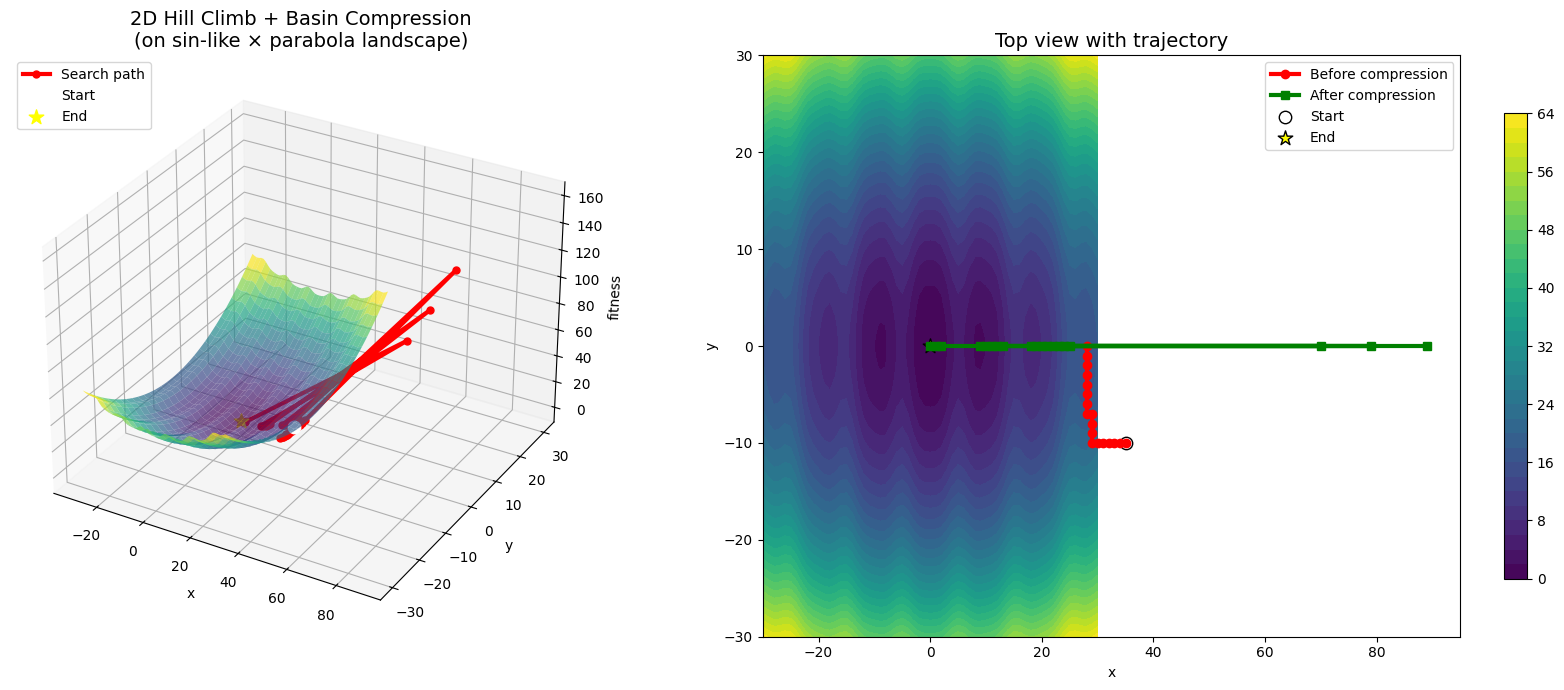

In [9]:

# ===============================
# 4) Run hill climb test on your 2D landscape
# ===============================
# 여기서는 앞에서 만든 fitness_sin_parabola_localmin_2d 를 f2d 라고 가정합니다.
# (필요하면 lambda로 감싸서 파라미터 고정해도 됩니다.)

START_2D = (35,-10)  # e.g., somewhere on one of the x-side local minima region

traj2d, cm2d = hill_climb_with_basin_compression_2d(
    f2d,
    start_xy=START_2D,
    max_iterations=10,
    basin_max_search=60,
    global_min_threshold=1e-6,
)

# ===============================
# 5) Visualize path on the surface
# ===============================
# NOTE: X_MIN, X_MAX, Y_MIN, Y_MAX, f2d must match your landscape settings.

x_grid = np.arange(X_MIN, X_MAX + 1, 1)
y_grid = np.arange(Y_MIN, Y_MAX + 1, 1)
X_vis, Y_vis = np.meshgrid(x_grid, y_grid)
Z_vis = np.zeros_like(X_vis, dtype=float)

for i in range(X_vis.shape[0]):
    for j in range(X_vis.shape[1]):
        Z_vis[i, j] = f2d(X_vis[i, j], Y_vis[i, j])

tx = np.array([p[0] for p in traj2d])
ty = np.array([p[1] for p in traj2d])
tf = np.array([p[2] for p in traj2d])
tcomp = np.array([p[3] for p in traj2d])

fig = plt.figure(figsize=(18, 7))

# --- 3D surface + path ---
ax3d = fig.add_subplot(1, 2, 1, projection='3d')
ax3d.plot_surface(X_vis, Y_vis, Z_vis, cmap='viridis', alpha=0.7, linewidth=0, antialiased=True)
ax3d.plot(tx, ty, tf, 'r-o', linewidth=3, markersize=5, label='Search path')

ax3d.scatter(tx[0], ty[0], tf[0], c='white', s=80, marker='o', label='Start')
ax3d.scatter(tx[-1], ty[-1], tf[-1], c='yellow', s=120, marker='*', label='End')

ax3d.set_title("2D Hill Climb + Basin Compression\n(on sin-like × parabola landscape)", fontsize=14)
ax3d.set_xlabel("x")
ax3d.set_ylabel("y")
ax3d.set_zlabel("fitness")
ax3d.legend(loc='upper left')

# --- Contour + path (before vs after compression) ---
ax2 = fig.add_subplot(1, 2, 2)
cs = ax2.contourf(X_vis, Y_vis, Z_vis, levels=40, cmap='viridis')
fig.colorbar(cs, ax=ax2, shrink=0.8)

idx_before = np.where(~tcomp)[0]
idx_after  = np.where(tcomp)[0]

if len(idx_before) > 0:
    ax2.plot(tx[idx_before], ty[idx_before], 'r-o',
             label='Before compression', linewidth=3)
if len(idx_after) > 0:
    ax2.plot(tx[idx_after], ty[idx_after], 'g-s',
             label='After compression', linewidth=3)

ax2.scatter(tx[0], ty[0], c='white', edgecolors='k', s=80, marker='o', label='Start')
ax2.scatter(tx[-1], ty[-1], c='yellow', edgecolors='k', s=120, marker='*', label='End')

ax2.set_title("Top view with trajectory", fontsize=14)
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()